In [1]:
# importar los paquetes necesarios
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
# inicializar la tasa de aprendizaje inicial, el número de épocas para entrenar,
# y tamaño de lote
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
# toma la lista de imágenes en nuestro directorio de conjuntos de datos, luego inicializa
# la lista de datos (es decir, imágenes) e imágenes de clase
print("Cargando imágenes ...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

Cargando imágenes ...


In [6]:
# recorrer las rutas de la imagen
for imagePath in imagePaths:
    # extrae la etiqueta de clase del nombre del archivo
    label = imagePath.split(os.path.sep)[-2]
    
    # cargar la imagen de entrada (224x224) y preprocesarla
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

   # actualizar las listas de datos y etiquetas, respectivamente
    data.append(image)
    labels.append(label)

In [7]:
# convierte los datos y las etiquetas en matrices NumPy
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
# realizar codificación one-hot en las etiquetas
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# particione los datos en divisiones de entrenamiento y prueba usando el 75% de
# los datos para entrenamiento y el 25% restante para pruebas
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [10]:
# construir el generador de imágenes de entrenamiento para el aumento de datos
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# cargue la red MobileNetV2, asegurándose de que los conjuntos de capas FC principales estén
# Parado
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [12]:
# construya la cabeza del modelo que se colocará encima de la
# el modelo base
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
# coloque el modelo FC de la cabeza encima del modelo base (esto se convertirá
# el modelo real que entrenaremos)
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
# recorrer todas las capas del modelo base y congelarlas para que
# * no * actualizarse durante el primer proceso de formación
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
# compila nuestro modelo
print("Compilando el modelo...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Compilando el modelo...


In [16]:
# capacitar al responsable de la red
print("jefe de entrenamiento ...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

jefe de entrenamiento ...
Epoch 1/20
34/34 [==============================] - 287s 8s/step - loss: 0.4758 - accuracy: 0.7734 - val_loss: 0.1892 - val_accuracy: 0.9457
Epoch 2/20
34/34 [==============================] - 198s 6s/step - loss: 0.1378 - accuracy: 0.9691 - val_loss: 0.0839 - val_accuracy: 0.9783
Epoch 3/20
34/34 [==============================] - 119s 3s/step - loss: 0.0759 - accuracy: 0.9822 - val_loss: 0.0571 - val_accuracy: 0.9819
Epoch 4/20
34/34 [==============================] - 117s 3s/step - loss: 0.0543 - accuracy: 0.9897 - val_loss: 0.0396 - val_accuracy: 0.9855
Epoch 5/20
34/34 [==============================] - 105s 3s/step - loss: 0.0386 - accuracy: 0.9945 - val_loss: 0.0319 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 79s 2s/step - loss: 0.0347 - accuracy: 0.9888 - val_loss: 0.0310 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 78s 2s/step - loss: 0.0334 - accuracy: 0.9906 - val_loss: 0.0260 - val_accura

In [17]:
# hacer predicciones sobre el conjunto de pruebas
print("evaluando la red .....")
predIdxs = model.predict(testX, batch_size=BS)

evaluando la red .....


In [18]:
# para cada imagen en el conjunto de prueba, necesitamos encontrar el índice del
# etiqueta con la probabilidad predicha más grande correspondiente
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
# mostrar un informe de clasificación con un formato agradable
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       138
without_mask       0.99      0.98      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [20]:
# guardar el modelo en disco
print("guardando el modelo...")
model.save('mimodelo.model', save_format="h5")

guardando el modelo...


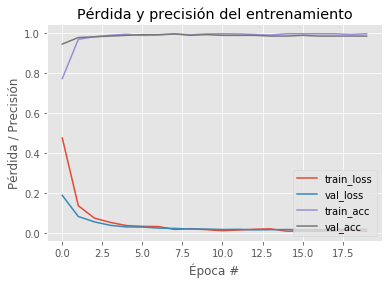

In [26]:
# trazar la pérdida y la precisión del entrenamiento
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Pérdida y precisión del entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Pérdida / Precisión")
plt.legend(loc="lower right")
plt.savefig('plot.png')

In [29]:
model.save('mimodelo.h5')
!tensorflowjs_converter --input_format keras mimodelo.h5 examples

2021-08-27 05:30:27.450785: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2021-08-27 05:30:27.612317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
